In [1]:
# plot PriLer R2 distribution
library(ggplot2)
library(ggrepel)
library(gridExtra)
library(latex2exp)
library(data.table)
library(jaccard)
library(ggpubr)
library(Matrix)
library(dplyr)
library(tibble)
library(circlize)

setwd('/psycl/g/mpsziller/lucia/')

tissues_model <- read.csv('PriLer_PROJECT_GTEx/INPUT_DATA/final_model_gtex.csv', h=F, stringsAsFactors = F)
outFold <- '/psycl/g/mpsziller/lucia/priler_project/Figure_CASTom-iGEx_paper/PriLer/'

colnames(tissues_model) <- c('tissue', 'type')
tissues_model$folder_train <- sapply(tissues_model$tissue, function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/noGWAS/', x))
tissues_model$folder_train[tissues_model$type == 'CAD'] <- sapply(tissues_model$tissue[tissues_model$type == 'CAD'] ,
                                                                  function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/CAD_GWAS_bin5e-2/', x))
tissues_model$folder_train[tissues_model$type == 'PGC'] <- sapply(tissues_model$tissue[tissues_model$type == 'PGC'], 
                                                                  function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/PGC_GWAS_bin1e-2/', x))

type <- c('All')
res_CMC <- paste0('PriLer_PROJECT_CMC/OUTPUT_CMC_SCRIPTS_v2/train_', type, '/200kb/')

df_prior <- list()
df_noprior <- list()
df_both <- list()
df_regSNPs <- list()
df_nrel <- list()

df_sampleSize <- read.table(sprintf('%s/PriLer_summary_tissueSpecific.txt', outFold), h=T, stringsAsFactors=F)

color_tissues <- fread('priler_project/Figure_CASTom-iGEx_paper/color_tissues.txt', h=T, stringsAsFactors=F, data.table = F)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [2]:
## load results ##
load_res <- function(fold, tissue){
    
    df <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', fold), h=T, stringsAsFactors = F, sep = '\t')
    df$tissue <- tissue
    df$n_regSNPs <- NA
    
    # reg-SNPs per gene, regardless category
    coef <- get(load(sprintf('%s/resPrior_regCoeffSnps_allchr.RData', fold)))
    for(id_chr in 1:length(coef)){
        n_snps <- colSums(coef[[id_chr]]!=0)
        df$n_regSNPs[df$chrom == paste0('chr', id_chr)] <- n_snps
    }
    df$n_regSNPs[is.na(df$dev)] <- NA
    
    return(df)
}

df <- load_res(res_CMC, tissue = 'DLPC_CMC')

for(i in 1:nrow(tissues_model)){
    #print(i)
    tmp <- load_res(fold = tissues_model$folder_train[i], tissue = tissues_model$tissue[i])
    df <- rbind(df, tmp)
}

df$reliable <- F
df$reliable[df$test_dev_geno>0 & df$dev_geno>0.01] <- T
df_gene <- df

# save overall
write.table(df_gene, sprintf('%s/resPrior_allTissues.txt', outFold), quote = F, sep = '\t', col.names = T, row.names = F)


In [3]:
# load results for CMC with different sample sizes

type <- c('Control50', 'Control100', 'Control150', 'ControlAll','All')
res_CMC_tot <- paste0('PriLer_PROJECT_CMC/OUTPUT_CMC_SCRIPTS_v2/train_', type, '/200kb/')

df_gene_CMC <- mapply(function(x,y) load_res(x, tissue = y), x = res_CMC_tot, y = type, SIMPLIFY = F) 
df_gene_CMC <- do.call(rbind, df_gene_CMC)

df_gene_CMC$reliable <- F
df_gene_CMC$reliable[df_gene_CMC$test_dev_geno>0 & df_gene_CMC$dev_geno>0.01] <- T
                      
df_sampleSize_CMC <- read.table('PriLer_PROJECT_CMC/OUTPUT_CMC_SCRIPTS_v2/nSamples_nRelGenes.txt',
                                h=T, stringsAsFactors = F)
nregSNPS_CMC <-c()
for(i in 1:length(res_CMC_tot)){
    tmp <- read.delim(sprintf('%s/nVariants_prior_compare.txt', res_CMC_tot[i]),
                      h=T, stringsAsFactors = F, sep = '\t')
    nregSNPS_CMC <- c(nregSNPS_CMC, sum(tmp$len[tmp$type == 'el-net learned prior']))
}

df_sampleSize_CMC <- df_sampleSize_CMC %>% 
                      select(-c(n_pathR, n_pathGO)) %>%
                      mutate(n_regSNPs = nregSNPS_CMC) %>%
                      rename(n_training_samples = n_samples,n_genes_reliable = n_genes)
                      
                      
write.table(df_gene_CMC, sprintf('%s/resPrior_CMC.txt', outFold), quote = F, sep = '\t', col.names = T, row.names = F)

df_sampleSize_CMC$col <- colorRamp2(breaks = c(0,10),
                                    colors = c("white", color_tissues$color[color_tissues$tissue == 'DLPC_CMC']))(6:10)

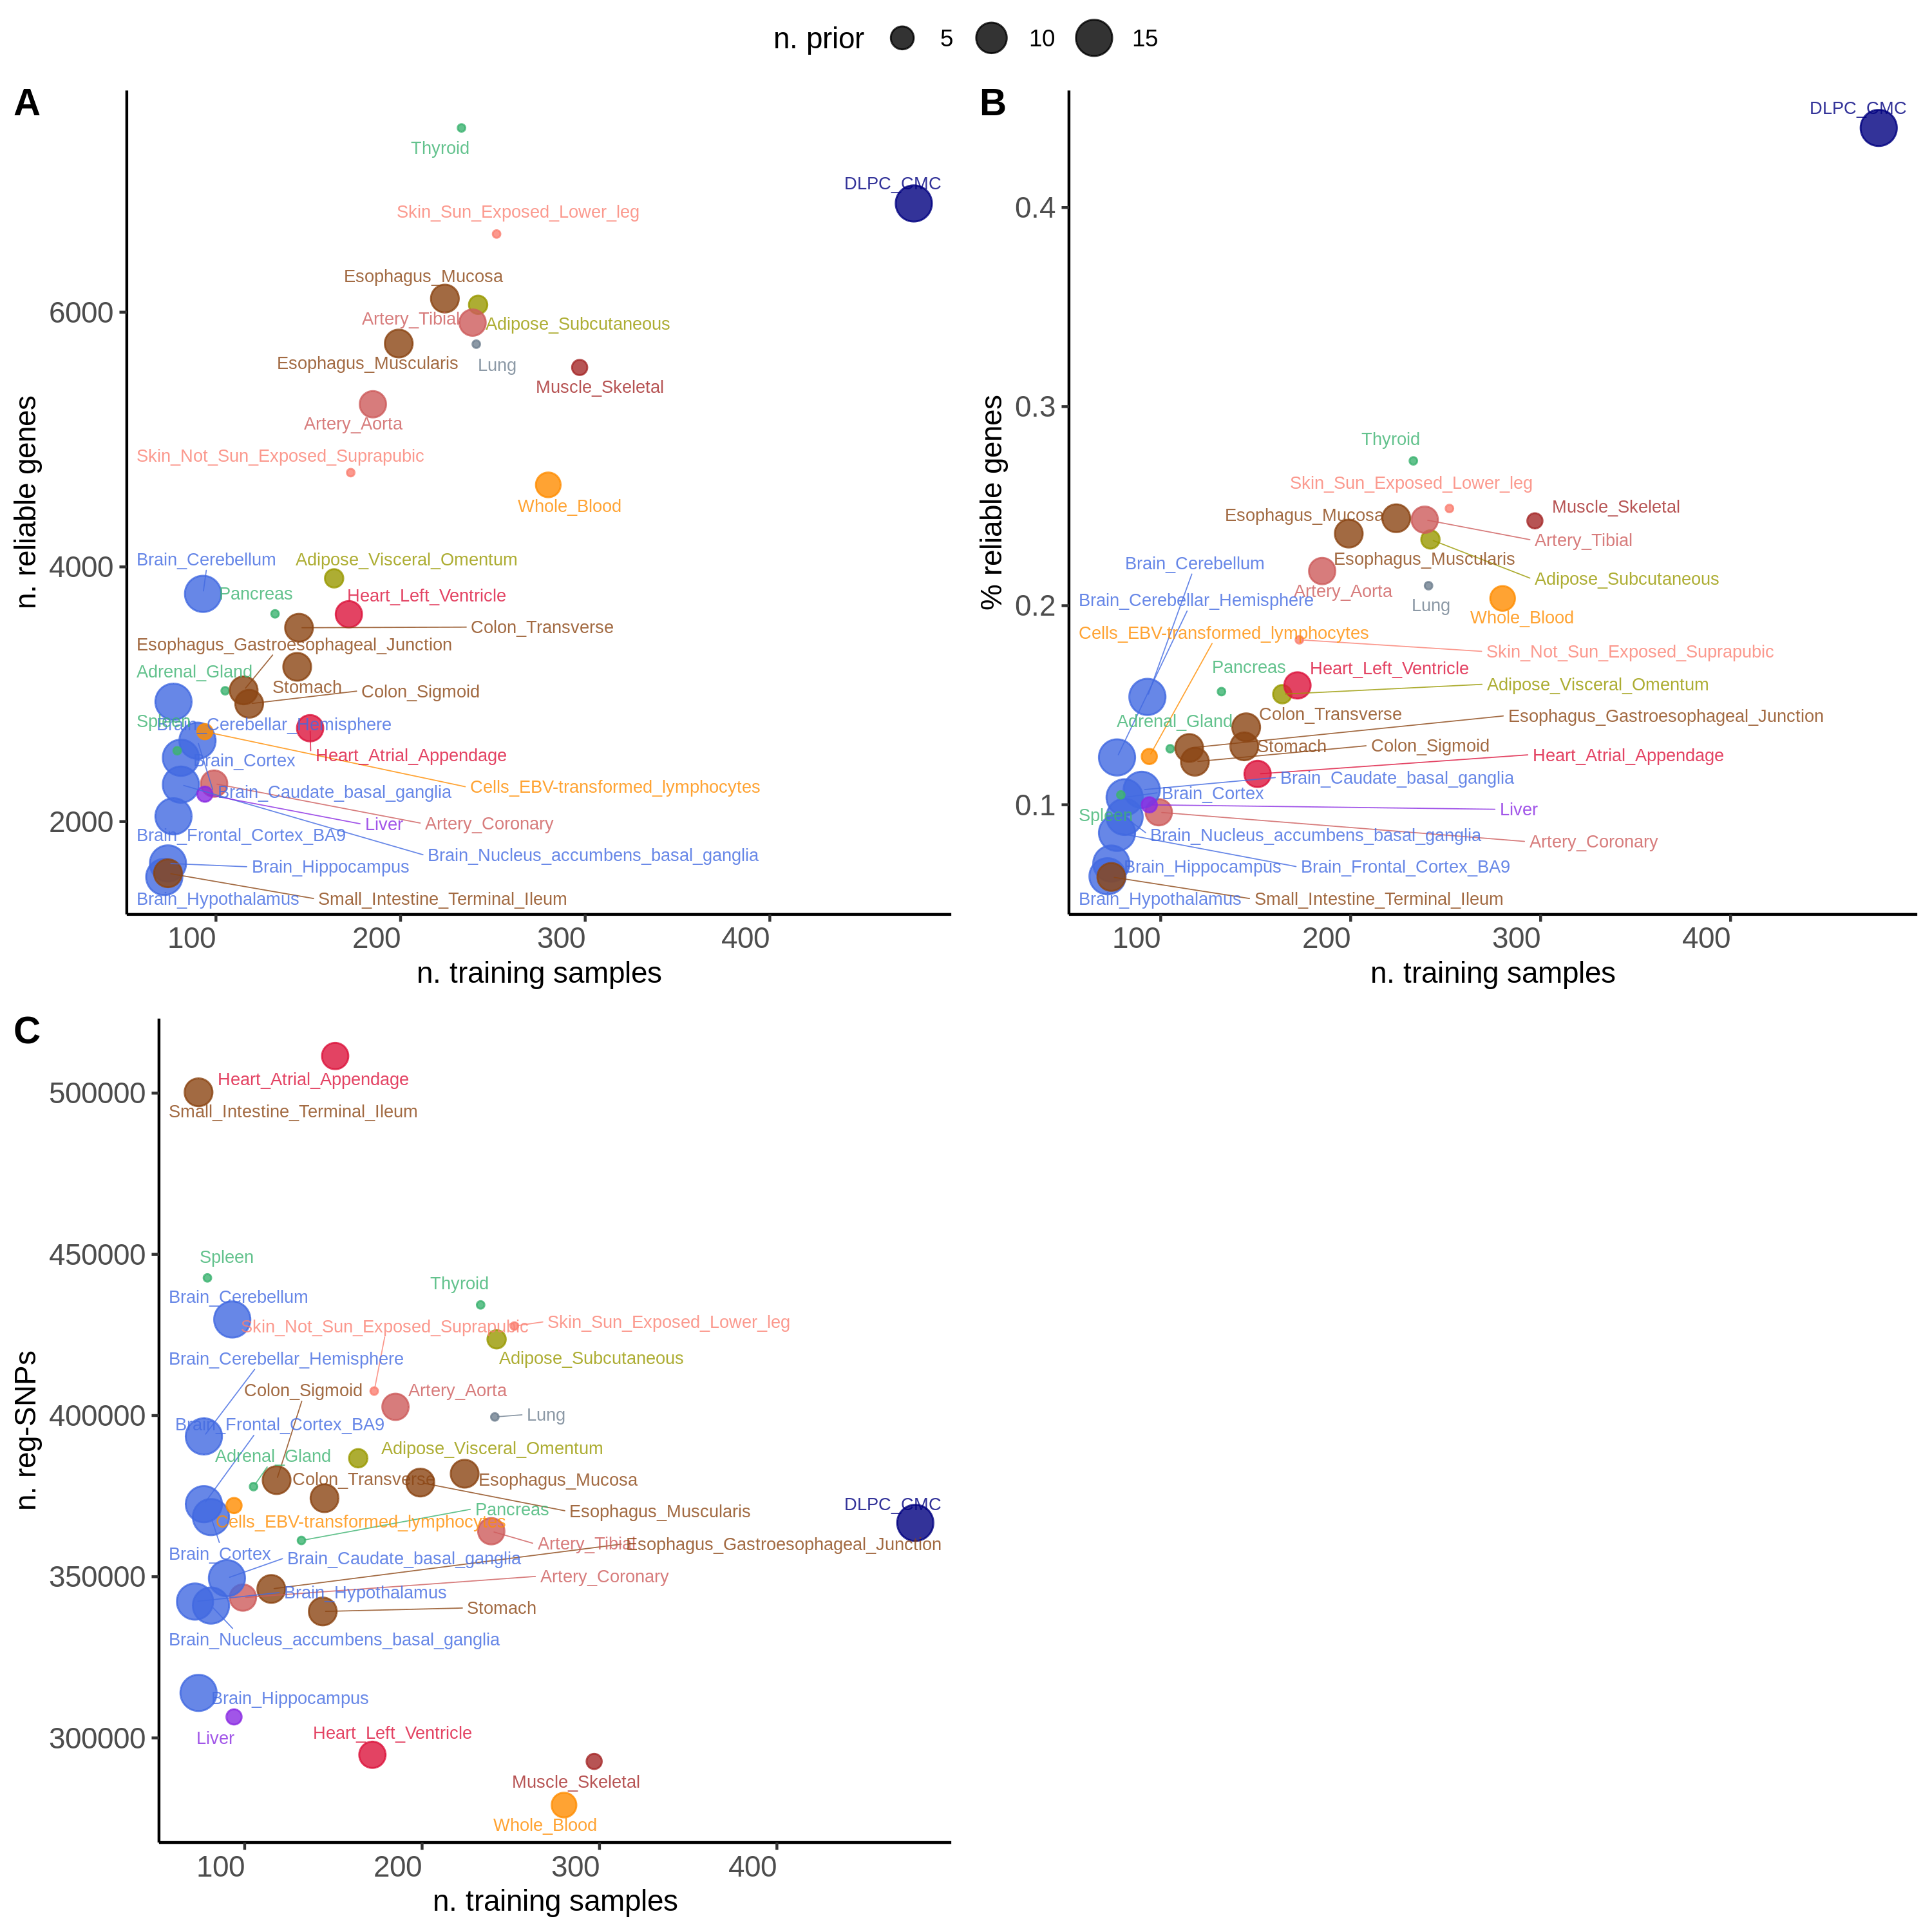

In [4]:
### plot n. reliable genes and regSNPs ###

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

n_relGenes <- data.frame(tissues = c('DLPC_CMC', tissues_model$tissue), 
                         col = color_tissues$color[match(c('DLPC_CMC', tissues_model$tissue), 
                                                         color_tissues$tissues)], 
                         stringsAsFactors = F)

df_nrel <- df_sampleSize
df_nrel$tissue <- factor(df_nrel$tissue, levels = df_nrel$tissue)
df_nrel$frac_genes_reliable <- df_nrel$n_genes_reliable/df_nrel$n_genes_total


pl_nrel <- ggplot(df_nrel, aes(x = n_training_samples, y = n_genes_reliable, 
                               color = tissue, size = n_prior_feat)) + 
  geom_point(alpha = 0.8)+
  xlab('n. training samples')+ ylab('n. reliable genes') + 
  theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, 
                  segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = 'none', size = guide_legend(title="n. prior"))+
  scale_color_manual(values = n_relGenes$col)

pl_prel <- ggplot(df_nrel, aes(x = n_training_samples, y = frac_genes_reliable, 
                               color = tissue, size = n_prior_feat)) + 
  geom_point(alpha = 0.8)+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+
  xlab('n. training samples')+ ylab('% reliable genes') + 
  theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, 
                  segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = 'none', size = guide_legend(title="n. prior"))+
  scale_color_manual(values = n_relGenes$col)

pl_nreg <- ggplot(df_nrel, aes(x = n_training_samples, y = n_regSNPs, 
                               color = tissue, size = n_prior_feat)) + 
  geom_point(alpha = 0.8)+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+
  xlab('n. training samples')+ ylab('n. reg-SNPs') + 
  theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, 
                  segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = 'none', size = guide_legend(title="n. prior"))+
  scale_color_manual(values = n_relGenes$col)

tot_pl <- ggarrange(pl_nrel, pl_prel, pl_nreg, common.legend = T, labels = c("A", "B", "C"), ncol = 2, nrow = 2)
tot_pl
ggsave(filename = sprintf('%sPriLer_summary_nsamples_allTissues.png', outFold), plot = tot_pl, width = 9, height = 9, dpi=300)
ggsave(filename = sprintf('%sPriLer_summary_nsamples_allTissues.pdf', outFold), plot = tot_pl, width = 9, height = 9, dpi=300)





In [5]:
# n. samples
test_corr <- cor.test(df_nrel$n_training_samples, df_nrel$n_genes_reliable)
print(sprintf('corr n.samples and n. rel genes: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

test_corr <- cor.test(df_nrel$n_training_samples, df_nrel$n_regSNPs)
print(sprintf('corr n. samples and n. reg-SNPs: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

test_corr <- cor.test(df_nrel$n_training_samples, df_nrel$frac_genes_reliable)
print(sprintf('corr n. samples and fraction rel genes: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

## n.prior
test_corr <- cor.test(df_nrel$n_prior_feat, df_nrel$n_genes_reliable)
print(sprintf('corr n. prior and n. rel genes: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

test_corr <- cor.test(df_nrel$n_prior_feat, df_nrel$n_regSNPs)
print(sprintf('corr n. prior and n. reg-SNPs: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

test_corr <- cor.test(df_nrel$n_prior_feat, df_nrel$frac_genes_reliable)
print(sprintf('corr n. prior and fraction rel genes: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))



[1] "corr n.samples and n. rel genes: 0.8538 (p=1.37979786548202e-10)"
[1] "corr n. samples and n. reg-SNPs: -0.0720 (p=0.685724503755971)"
[1] "corr n. samples and fraction rel genes: 0.9485 (p=1.57347844417917e-17)"
[1] "corr n. prior and n. rel genes: -0.3804 (p=0.0264837058574286)"
[1] "corr n. prior and n. reg-SNPs: -0.1579 (p=0.372377741649648)"
[1] "corr n. prior and fraction rel genes: -0.2191 (p=0.213107236791986)"


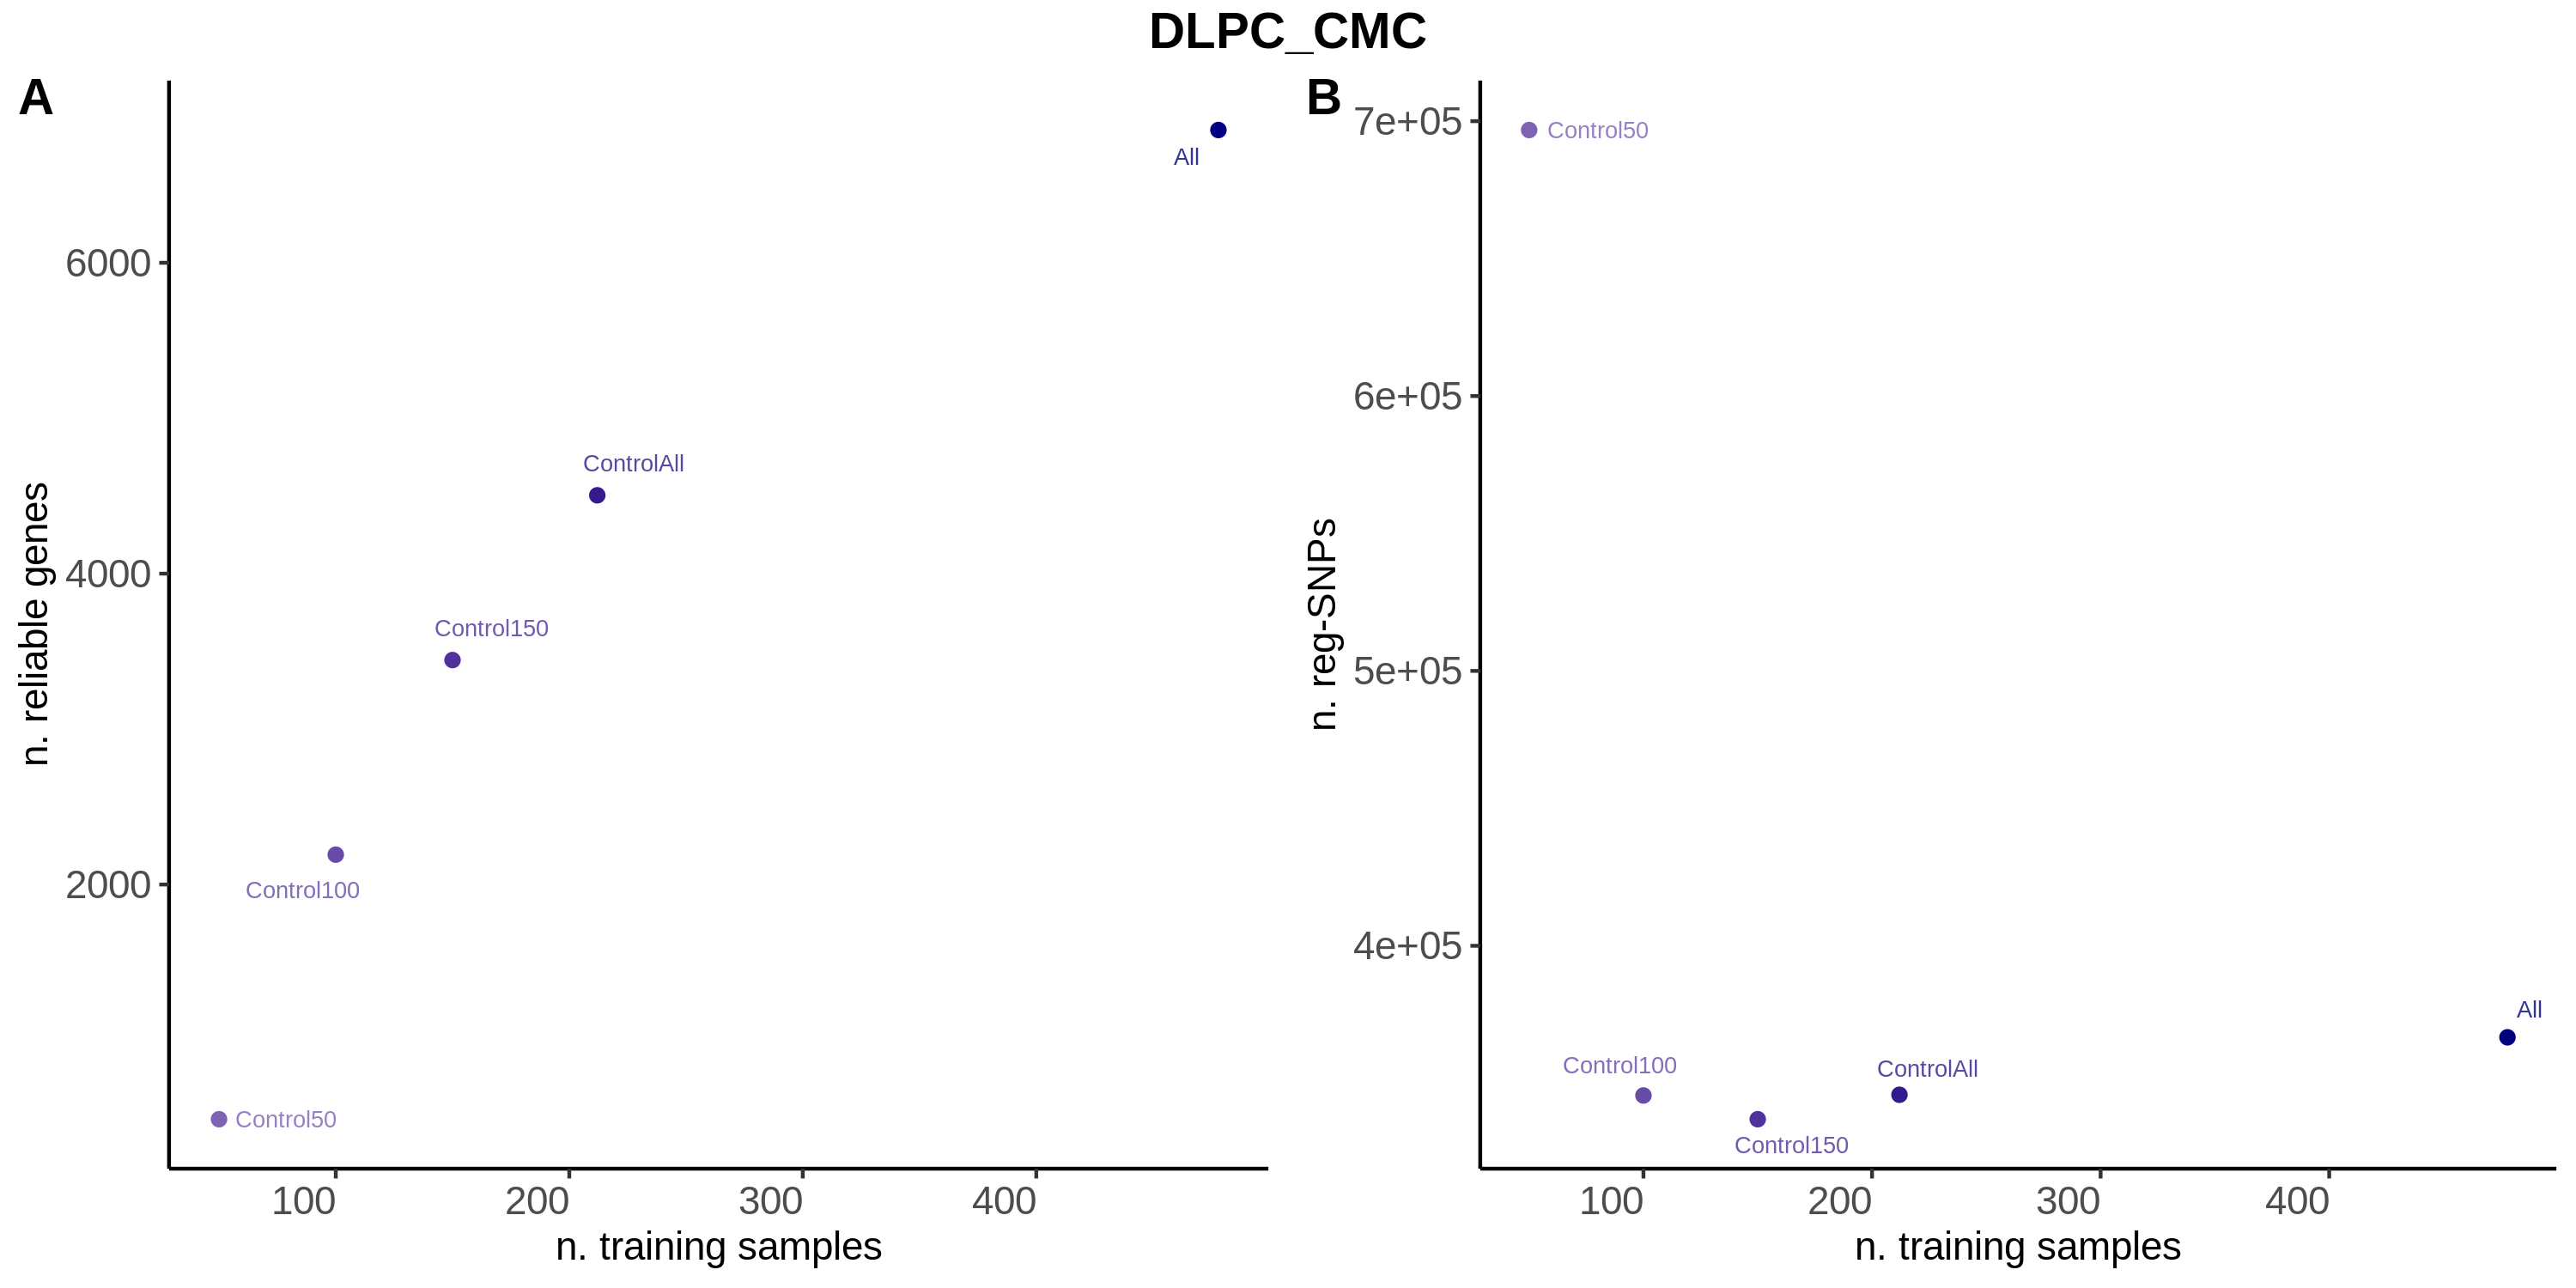

In [6]:
### plot n. reliable genes and regSNPs for CMC ###

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

df_nrel <- df_sampleSize_CMC
df_nrel$tissue <- factor(df_nrel$type, levels = df_nrel$type)

pl_nrel <- ggplot(df_nrel, aes(x = n_training_samples, y = n_genes_reliable, 
                               color = tissue)) + 
  geom_point(alpha = 2)+
  xlab('n. training samples')+ ylab('n. reliable genes') + 
  theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, 
                  segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = 'none')+
  scale_color_manual(values = df_nrel$col)

pl_nreg <- ggplot(df_nrel, aes(x = n_training_samples, y = n_regSNPs, 
                               color = tissue)) + 
  geom_point(alpha = 2)+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+
  xlab('n. training samples')+ ylab('n. reg-SNPs') + 
  theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, 
                  segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = 'none')+
  scale_color_manual(values = df_nrel$col)

tot_pl <- ggarrange(pl_nrel, pl_nreg , common.legend = T, labels = c("A", "B"), ncol = 2, nrow = 1)
tot_pl <- annotate_figure(tot_pl,top = text_grob("DLPC_CMC", face = "bold", size = 14))
tot_pl
ggsave(filename = sprintf('%sPriLer_summary_nsamples_CMC.png', outFold), plot = tot_pl, width = 8, height = 4, dpi=300)
ggsave(filename = sprintf('%sPriLer_summary_nsamples_CMC.pdf', outFold), plot = tot_pl, width = 8, height = 4, dpi=300)


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


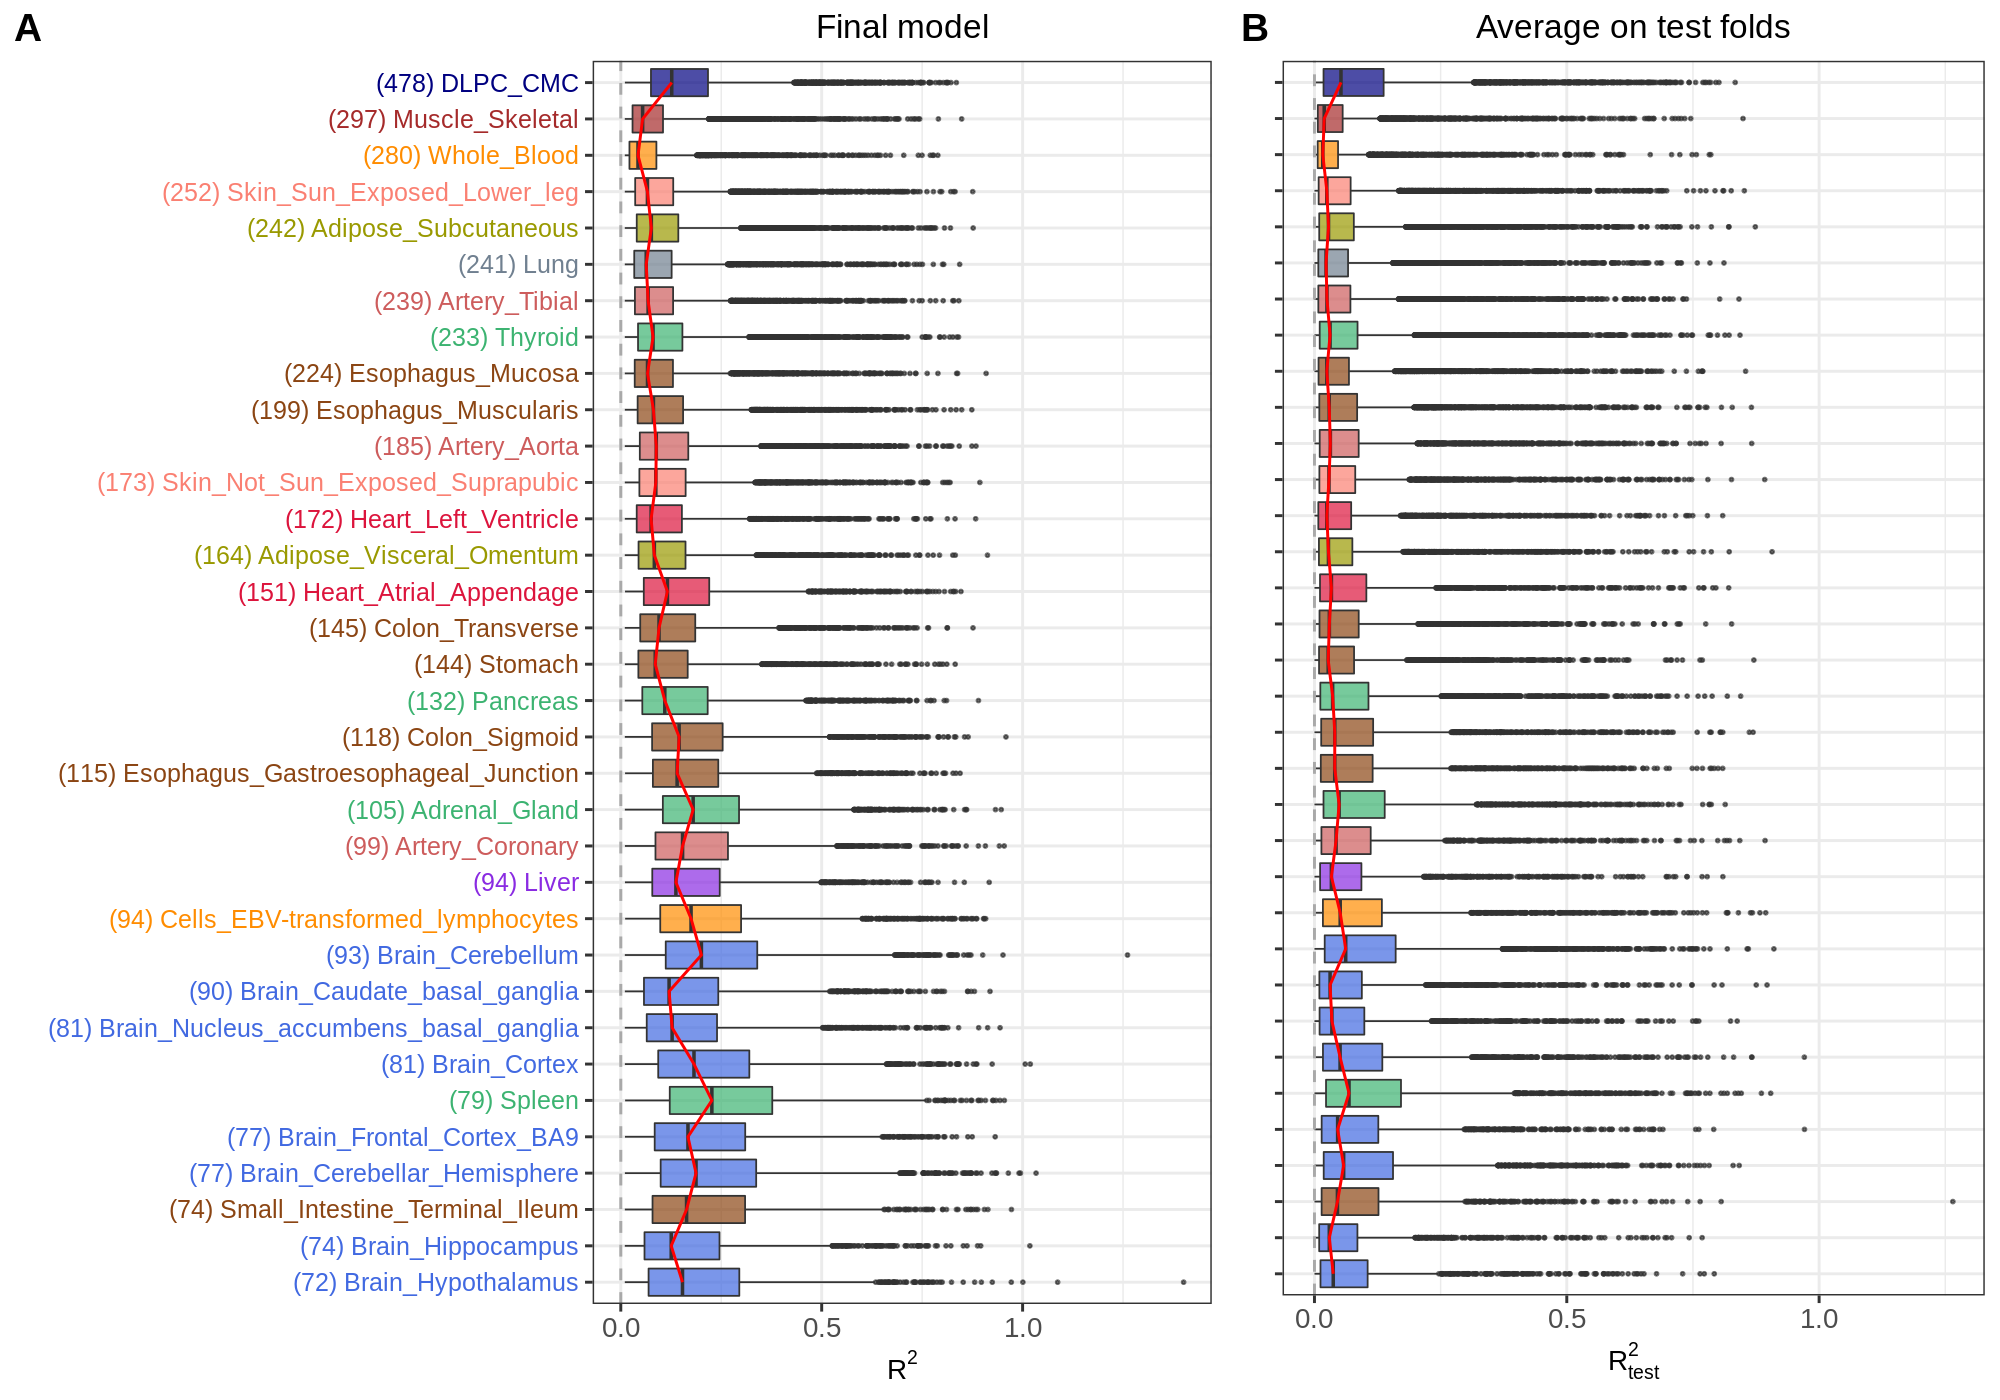

In [7]:
### plot distribution R2 dev_geno and test_dev_geno ###

options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


order_t <- order(df_sampleSize$n_training_samples)
df_plot <- df_gene
df_plot$tissue_name <- NA
df_sampleSize$tissue_name <- NA
for(i in 1:nrow(df_sampleSize)){
    df_sampleSize$tissue_name[i] <- sprintf("(%i) %s",df_sampleSize$n_training_samples[i],
                                                                              df_sampleSize$tissue[i]) 
    df_plot$tissue_name[df_plot$tissue == df_sampleSize$tissue[i]] <- df_sampleSize$tissue_name[i]
} 
df_plot$tissue_name <- factor(df_plot$tissue_name, levels = df_sampleSize$tissue_name[order_t])
df_med <- df_plot %>% 
          filter(reliable) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno)) %>%
          mutate(n=df_sampleSize$n_training_samples[order_t])


pl_box_R2 <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = n_relGenes$col[order_t])+
  ggtitle('Final model')+
  geom_line(data = df_med, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = n_relGenes$col[order_t]),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

pl_box_R2_test <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=test_dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R[test]^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = n_relGenes$col[order_t])+
  geom_line(data = df_med, mapping = aes(x = tissue_name, y = med_test, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  ggtitle('Average on test folds')+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

tot_pl <- ggarrange(pl_box_R2, pl_box_R2_test, 
                    labels = c("A", "B"), ncol = 2, nrow = 1, widths = c(1, 0.63))
tot_pl
ggsave(filename = sprintf('%sPriLer_R2.png', outFold), plot = tot_pl, width = 10, height = 7, dpi=300)
ggsave(filename = sprintf('%sPriLer_R2.pdf', outFold), plot = tot_pl, width = 10, height = 7, dpi=300)


In [8]:
# median correlation with n.samples
test_corr <- cor.test(df_med$n, df_med$med)
print(sprintf('corr n. samples and median R2: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))

test_corr <- cor.test(df_med$n, df_med$med_test)
print(sprintf('corr n. samples and median test R2: %.4f (p=%s)', test_corr$estimate, as.character(test_corr$p.value)))



[1] "corr n. samples and median R2: -0.6469 (p=3.56795714154075e-05)"
[1] "corr n. samples and median test R2: -0.4062 (p=0.0171426192278215)"


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


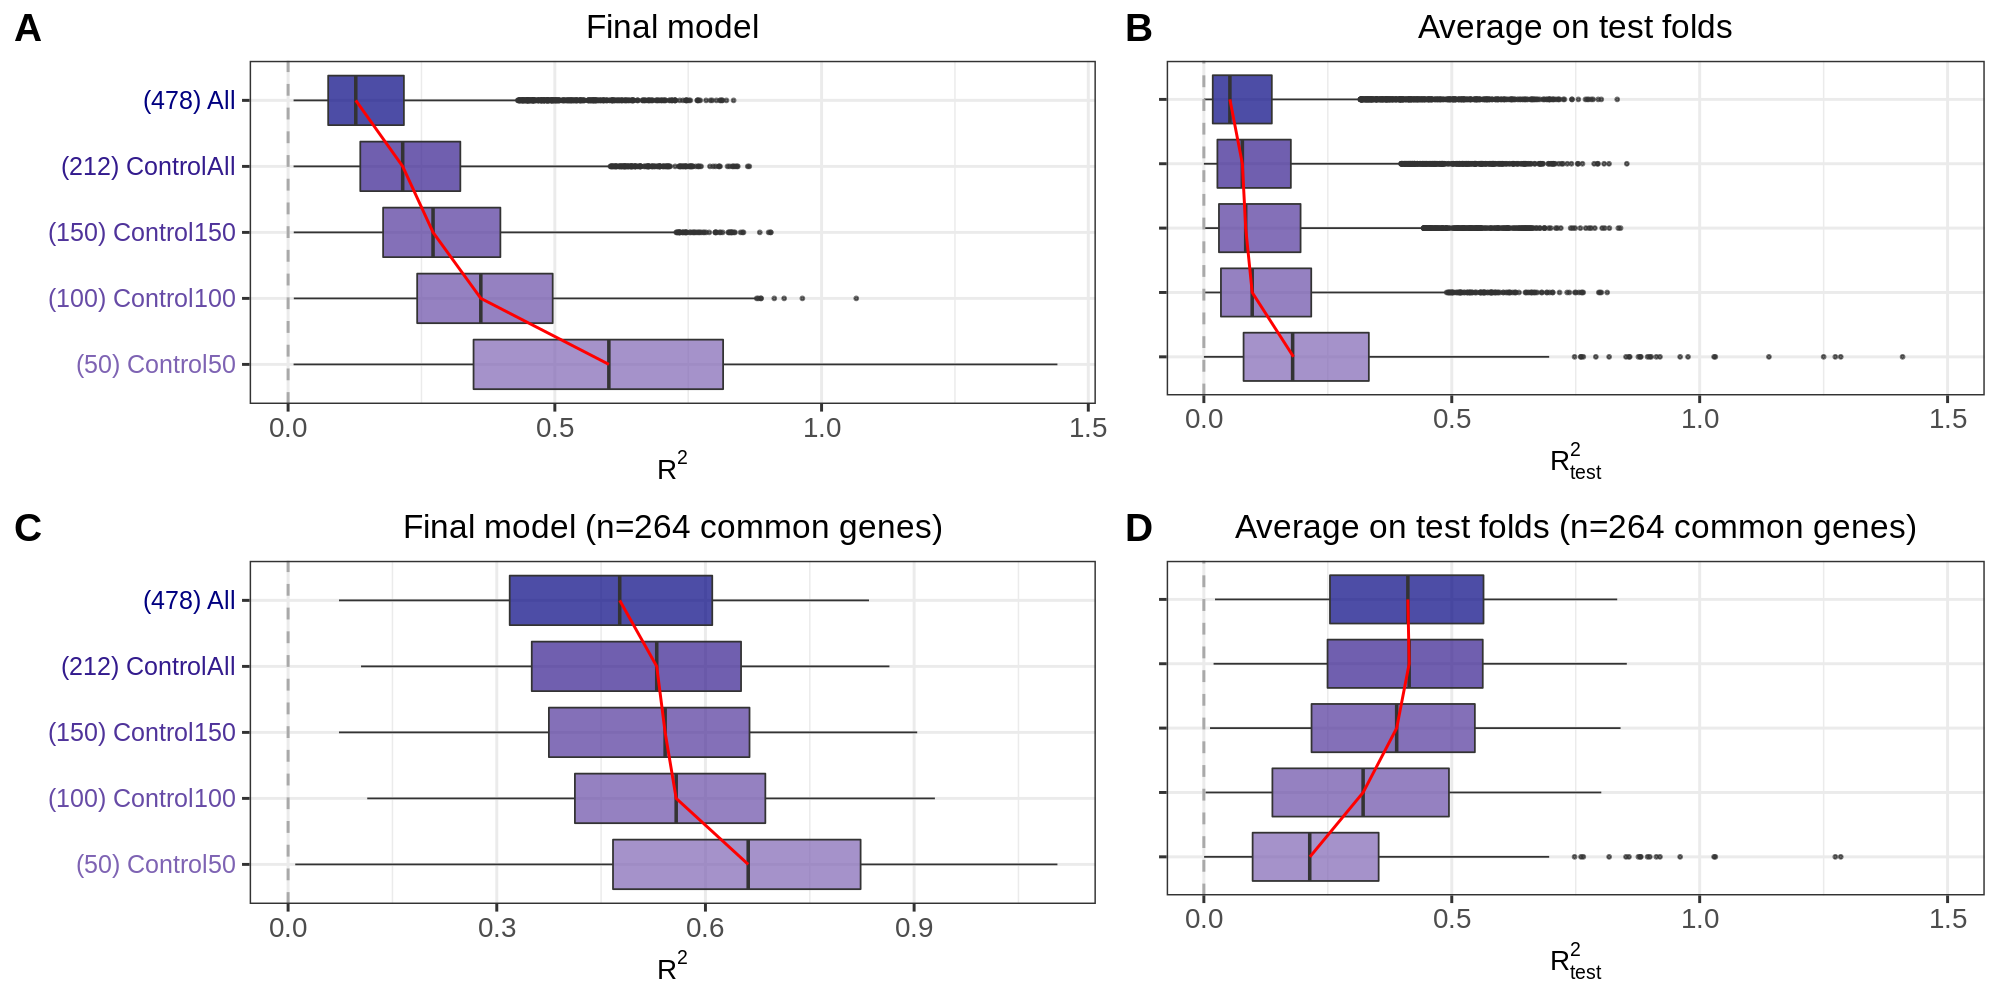

In [9]:
### plot distribution R2 dev_geno and test_dev_geno CMC ###

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

id <- names(which(table(df_gene_CMC$ensembl_gene_id[df_gene_CMC$reliable]) == 5))
df_plot <- df_gene_CMC
df_plot$tissue_name <- NA
df_sampleSize_CMC$tissue_name <- NA
for(i in 1:nrow(df_sampleSize_CMC)){
    df_sampleSize_CMC$tissue_name[i] <- sprintf("(%i) %s",df_sampleSize_CMC$n_training_samples[i],
                                                                              df_sampleSize_CMC$type[i]) 
    df_plot$tissue_name[df_plot$tissue == df_sampleSize_CMC$type[i]] <- df_sampleSize_CMC$tissue_name[i]
} 
df_plot$tissue_name <- factor(df_plot$tissue_name, levels = df_sampleSize_CMC$tissue_name)

df_med <- df_plot %>% 
          filter(reliable) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno)) %>%
          mutate(n=df_sampleSize_CMC$n_training_samples)

pl_box_R2 <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = df_sampleSize_CMC$col)+
  ggtitle('Final model')+
  geom_line(data = df_med, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = df_sampleSize_CMC$col),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

pl_box_R2_test <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=test_dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R[test]^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  ylim(0, 1.5)+
  scale_fill_manual(values = df_sampleSize_CMC$col)+
  geom_line(data = df_med, mapping = aes(x = tissue_name, y = med_test, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  ggtitle('Average on test folds')+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

# common genes
df_med_c <- df_plot %>% 
          filter(reliable, ensembl_gene_id %in% id) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno)) %>%
          mutate(n=df_sampleSize_CMC$n_training_samples)

pl_box_R2_c <- ggplot(subset(df_plot, reliable & ensembl_gene_id %in% id), 
                    aes(x = tissue_name, y=dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = df_sampleSize_CMC$col)+
  ggtitle(sprintf('Final model (n=%i common genes)', length(id)))+
  geom_line(data = df_med_c, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = df_sampleSize_CMC$col),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

pl_box_R2_test_c <- ggplot(subset(df_plot, reliable & ensembl_gene_id %in% id), 
                    aes(x = tissue_name, y=test_dev_geno, fill = tissue_name)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R[test]^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  ylim(0, 1.5)+
  scale_fill_manual(values = df_sampleSize_CMC$col)+
  geom_line(data = df_med_c, mapping = aes(x = tissue_name, y = med_test, group=1), 
            color = 'red')+
  #scale_y_continuous(trans=weird)+
  ggtitle(sprintf('Average on test folds (n=%i common genes)', length(id)))+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()



tot_pl <- ggarrange(pl_box_R2, pl_box_R2_test, pl_box_R2_c, pl_box_R2_test_c,
                    labels = c("A", "B", "C", "D"), ncol = 2, nrow = 2, widths = c(1, 0.8))
tot_pl
ggsave(filename = sprintf('%sPriLer_R2_CMC.png', outFold), plot = tot_pl, width = 10, height = 5, dpi=300)
ggsave(filename = sprintf('%sPriLer_R2_CMC.pdf', outFold), plot = tot_pl, width = 10, height = 5, dpi=300)

In [10]:
table(df_plot$test_dev_geno[df_plot$reliable] > 1.5, df_plot$tissue[df_plot$reliable])
table(df_plot$dev_geno[df_plot$reliable] > 1.5 , df_plot$tissue[df_plot$reliable])

table(df_plot$test_dev_geno[df_plot$ensembl_gene_id %in% id] > 1.5 , df_plot$tissue[df_plot$ensembl_gene_id %in% id])
table(df_plot$dev_geno[df_plot$ensembl_gene_id %in% id] > 1.5 , df_plot$tissue[df_plot$ensembl_gene_id %in% id])


       
         All Control100 Control150 Control50 ControlAll
  FALSE 6854       2192       3444       485       4504
  TRUE     0          0          0         5          0

       
         All Control100 Control150 Control50 ControlAll
  FALSE 6854       2192       3444       490       4504

       
        All Control100 Control150 Control50 ControlAll
  FALSE 264        264        264       263        264
  TRUE    0          0          0         1          0

       
        All Control100 Control150 Control50 ControlAll
  FALSE 264        264        264       264        264

`summarise()` has grouped output by 'tissue_name'. You can override using the `.groups` argument.

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


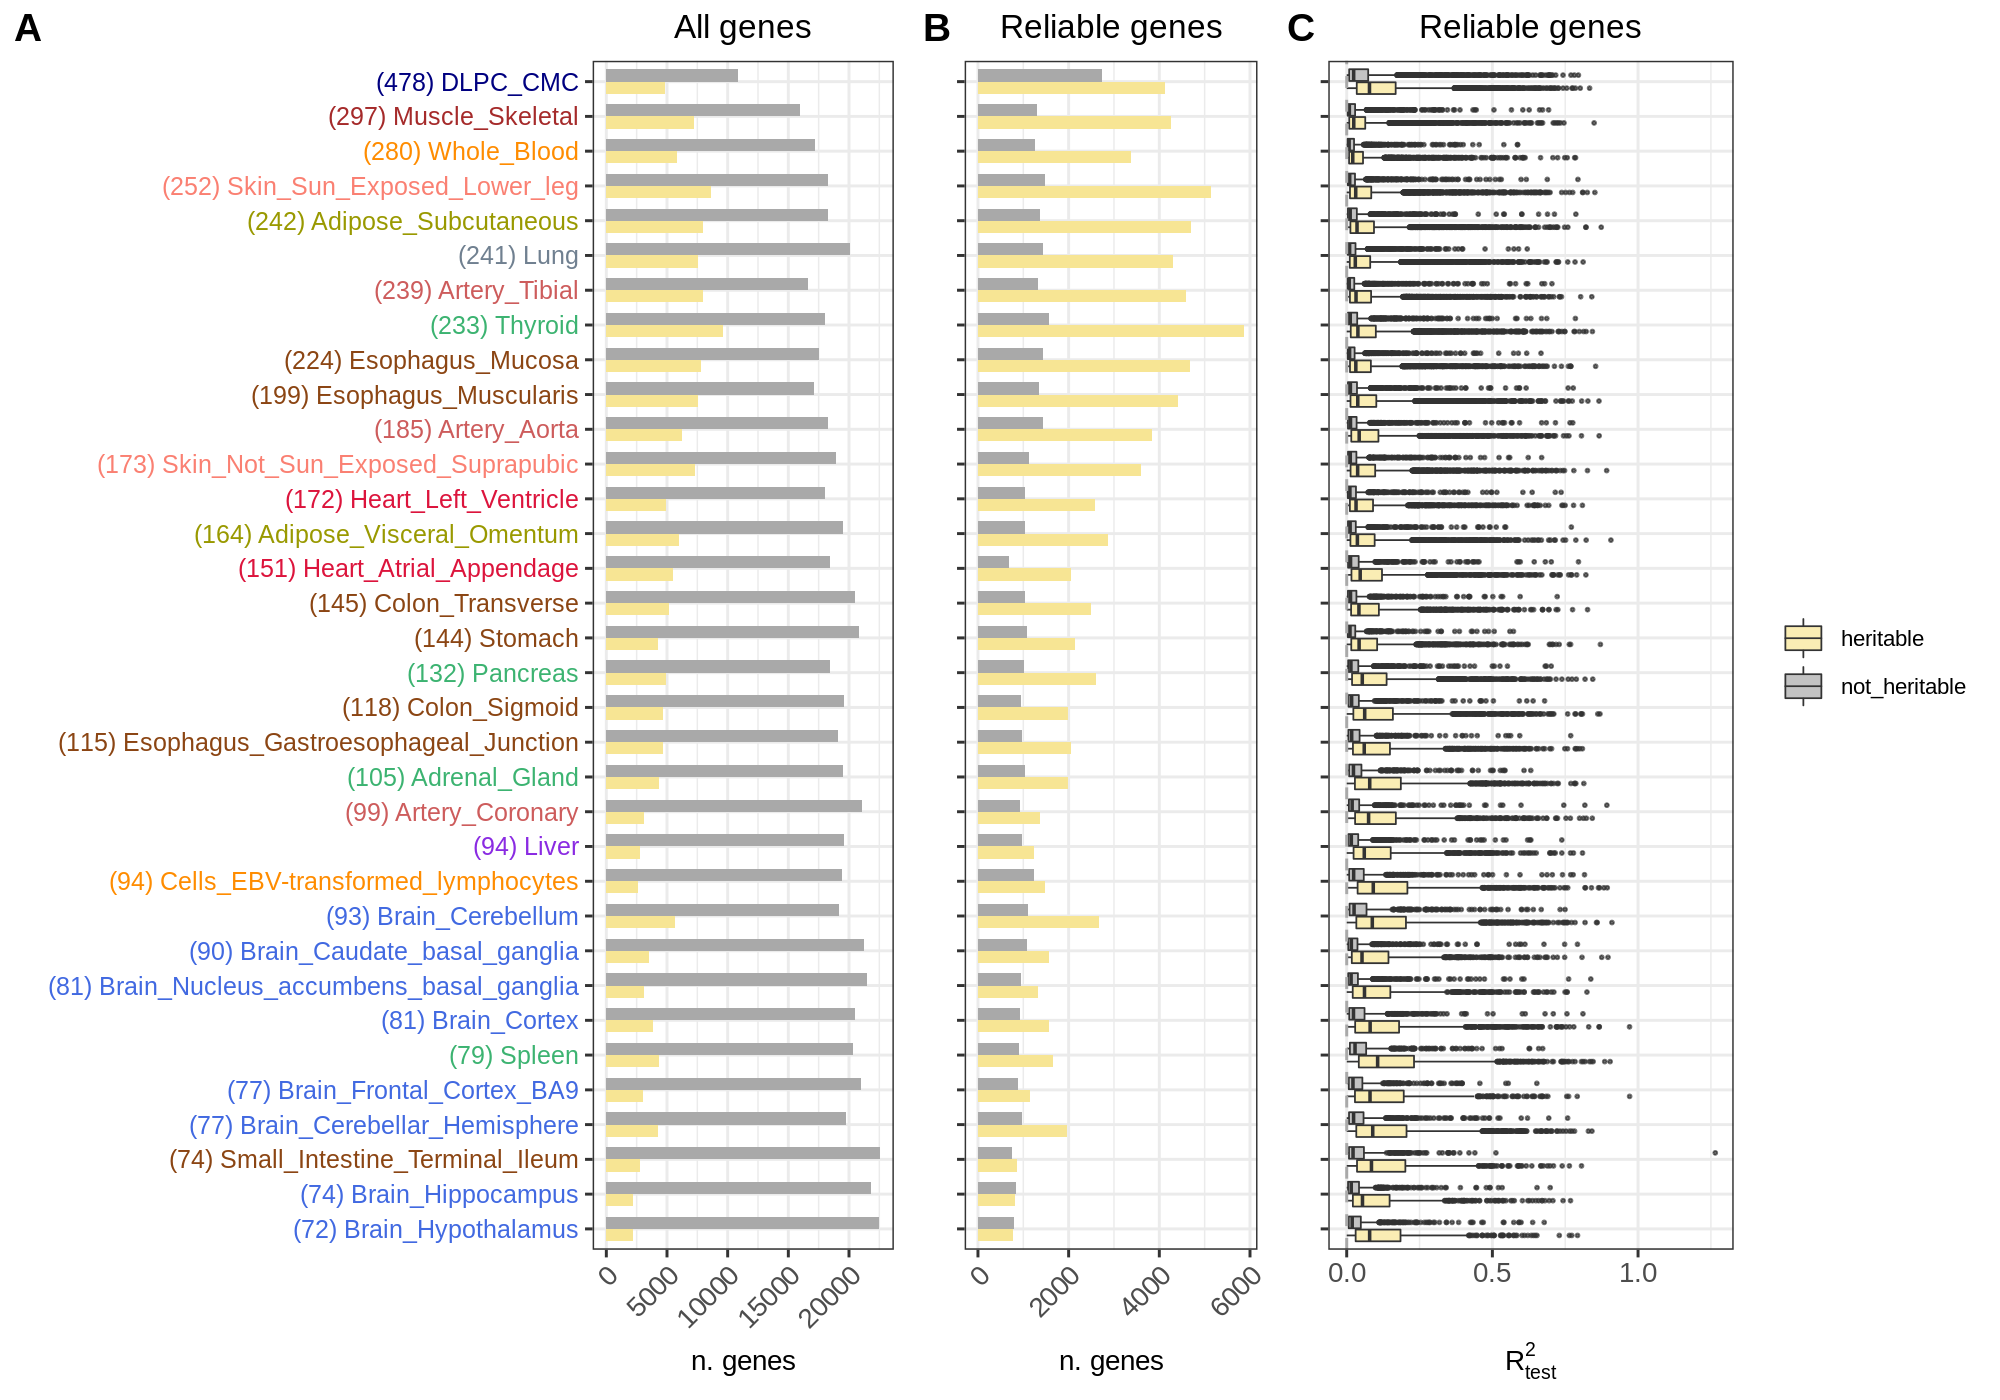

In [11]:
# plot different distribution heritable/non-heritable
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

order_t <- order(df_sampleSize$n_training_samples)
df_plot <- df_gene
df_plot$tissue_name <- NA
df_sampleSize$tissue_name <- NA
for(i in 1:nrow(df_sampleSize)){
    df_sampleSize$tissue_name[i] <- sprintf("(%i) %s",df_sampleSize$n_training_samples[i],
                                                                              df_sampleSize$tissue[i]) 
    df_plot$tissue_name[df_plot$tissue == df_sampleSize$tissue[i]] <- df_sampleSize$tissue_name[i]
} 
df_plot$tissue_name <- factor(df_plot$tissue_name, levels = df_sampleSize$tissue_name[order_t])

pl_box_R2_test <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=test_dev_geno, fill = type)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ 
  ylab(expression(R[test]^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = c('#F7E594', 'darkgrey'))+
  #scale_y_continuous(trans=weird)+
  ggtitle('Reliable genes')+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        # axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = n_relGenes$col[order_t]),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 10), legend.position = 'right',  legend.title = element_blank())+
        coord_flip()

df_plot_summary <-  df_plot %>% 
          filter(reliable) %>%
          group_by(tissue_name, type) %>% 
          summarise(count = n())
                   
pl_count_rel <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, fill=type)) + 
  geom_bar(position = position_dodge(), width = 0.7)+ 
  ylab('n. genes')+ 
  xlab('')+ theme_bw()+ 
  ggtitle('Reliable genes')+
  scale_fill_manual(values = c('#F7E594', 'darkgrey'))+
  #scale_y_continuous(trans=weird)+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10, angle = 45, hjust = 1), 
        legend.position = 'none', legend.title = element_blank())+
        coord_flip()

pl_count <- ggplot(df_plot, 
                    aes(x = tissue_name, fill=type)) + 
  geom_bar(position = position_dodge(), width = 0.7)+ 
  ylab('n. genes')+ 
  xlab('')+ theme_bw()+ 
  ggtitle('All genes')+
  scale_fill_manual(values = c('#F7E594', 'darkgrey'))+
  #scale_y_continuous(trans=weird)+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = n_relGenes$col[order_t]),
        # axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10, angle = 45, hjust = 1), 
        legend.position = 'none', legend.title = element_blank())+
        coord_flip()

tot_pl <- ggarrange(pl_count, pl_count_rel, pl_box_R2_test,
                    labels = c("A", "B", "C"), ncol = 3, nrow = 1, widths = c(1, 0.4, 0.8), align = 'h')
tot_pl
ggsave(filename = sprintf('%sPriLer_R2_heritable_and_not.png', outFold), plot = tot_pl, width = 10, height = 7, dpi=300)
ggsave(filename = sprintf('%sPriLer_R2_heritable_and_not.pdf', outFold), plot = tot_pl, width = 10, height = 7, dpi=300)



In [48]:
# test differences
library(stringr)
df_plot_summary <-  df_plot %>% 
          filter(reliable) %>%
          group_by(tissue_name) %>% 
          summarise(prop_heritable = sum(type == 'heritable')/n(),
                    test_wmw = wilcox.test(x = test_dev_geno[type == 'heritable'], 
                                           y = test_dev_geno[type == 'not_heritable'])$p.value, 
                    diff_avg = median(test_dev_geno[type == 'heritable']) - 
                    median(test_dev_geno[type == 'not_heritable'])) %>%
          arrange(prop_heritable) %>%
          mutate(n_sample_training = as.numeric(str_extract_all(tissue_name,  "(?<=\\().+?(?=\\))", 
                                                                simplify = TRUE)[,1]))
df_plot_summary
print(paste0("average median difference: ", mean(df_plot_summary$diff_avg)))
cor_n_diff = cor(x = df_plot_summary$n_sample_training, y = df_plot_summary$diff_avg, method = "spearman")
cor_n_prop = cor(x = df_plot_summary$n_sample_training, y = df_plot_summary$prop_heritable, method = "spearman")
print(paste0("correlation n. samples and median difference (h. vs not h.): ", cor_n_diff))
print(paste0("correlation n. samples and proportion heritable genes: ", cor_n_prop))


# overall
df_plot %>% 
  filter(reliable) %>%
  summarise(test_wmw = wilcox.test(x = test_dev_geno[type == 'heritable'], 
                                           y = test_dev_geno[type == 'not_heritable'])$p.value, 
           diff_avg = median(test_dev_geno[type == 'heritable']) - 
                    median(test_dev_geno[type == 'not_heritable']))


tissue_name,prop_heritable,test_wmw,diff_avg,n_sample_training
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
(74) Brain_Hippocampus,0.4949132,2.773689e-57,0.03860465,74
(72) Brain_Hypothalamus,0.4971246,1.333419e-64,0.05989007,72
(74) Small_Intestine_Terminal_Ileum,0.5338770,1.716669e-64,0.06309615,74
(94) Cells_EBV-transformed_lymphocytes,0.5458241,5.251866e-116,0.06735898,94
(94) Liver,0.5620767,6.953060e-86,0.04448467,94
(77) Brain_Frontal_Cortex_BA9,0.5668790,2.474643e-75,0.05858106,77
(81) Brain_Nucleus_accumbens_basal_ganglia,0.5825328,4.244383e-89,0.04600269,81
(90) Brain_Caudate_basal_ganglia,0.5927894,3.698425e-80,0.03662445,90
(99) Artery_Coronary,0.5992167,1.880195e-99,0.05641124,99


[1] "average median difference: 0.0398169959071153"
[1] "correlation n. samples and median difference (h. vs not h.): -0.812777051572935"
[1] "correlation n. samples and proportion heritable genes: 0.810484525101782"


test_wmw,diff_avg
<dbl>,<dbl>
0,0.02919707
